In [1]:
# All imports should be in first cell
import cartopy
import GMesh
import imp
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read a target grid

In [2]:
#Read in Mercator grid for 1/8 degree model
targ_grid =  netCDF4.Dataset('/net2/nnz/grid_generation/workdir/grid_OM4p125_new/tripolar_disp_res8.ncSO.nc')
targ_lon = np.array(targ_grid.variables['x'])
targ_lat = np.array(targ_grid.variables['y'])

## Partition the Target grid into non-intersecting blocks
 The 1/8 degree grid is too big to be handled in one go (my 64G machine runs out of memory and starts  to swap rendering the machine useless). Hence, we break the target to pieces and handle them one at a time. 

Future enhancement: 

    Make the block shape arbitrary rather than 2x2
    Delegate these blocks to GPU tasks.

In [4]:
#This works only if the target mesh is "regular"! Niki: Find the mathematical buzzword for "regular"!!
#Is this a regular mesh?
targ_lon[1,:] - targ_lon[0,:]

def block_array_1d(a,xb=2):
    a_win = []
    i0 = 0
    lx = a.shape[0]//xb
    for k in range(xb):
        i1=min(a.shape[0],i0+lx)
        a_win.append(a[i0:i1])
        i0=i1
    return a_win

lons=block_array_1d(targ_lon[0,:],10)
lats=block_array_1d(targ_lat[:,0],2)

lons[0].shape,lats[0].shape

((576,), (226,))

Target region: -84.0 -72.4297845672  to  -48.0625 -66.9086459223
<GMesh nj:225 ni:575 shape:(225,575)>


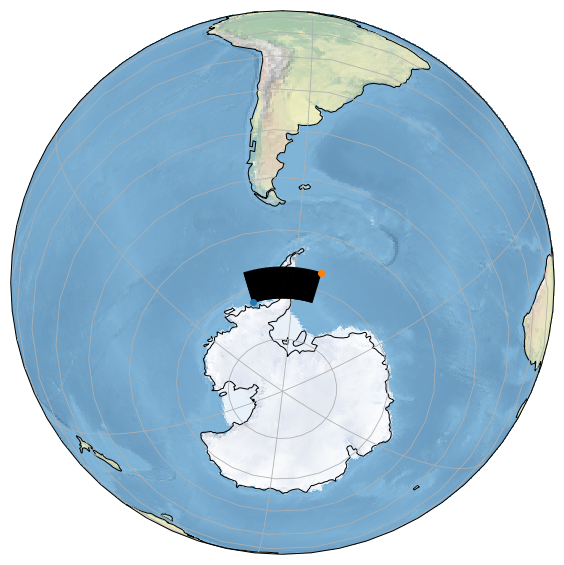

In [13]:
plt.figure(figsize=(10,10))
lon = lons[6]
lat = lats[1]

lonc = (lon[0]+lon[-1])/2
latc = (lat[0]+lat[-1])/2
print("Target region:", lon[0],lat[0], " to ",lon[-1],lat[-1])

#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
imp.reload(GMesh)
target_mesh = GMesh.GMesh( lon=lon, lat=lat )
print( target_mesh )
#ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective())
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lonc, central_latitude=latc))
ax.set_global()
ax.stock_img()
ax.coastlines()
ax.gridlines()
target_mesh.plot(ax,subsample=10, transform=cartopy.crs.Geodetic())
plt.plot(lon[0],  lat[0], 'o', transform=cartopy.crs.PlateCarree())
plt.plot(lon[-1], lat[-1], 'o', transform=cartopy.crs.PlateCarree())


# Open and read a topographic dataset

Open a topography dataset, check that the topography is on a uniform grid.

In [14]:
# URL of topographic data, names of longitude, latitude and elevation variables
# url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_08_v1.nc','longitude','latitude','depth'
url,vx,vy,ve = '/net2/nnz/thin-wall-topography/python/workdir/GEBCO_2014_2D.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO1/.z_bedrock/dods','lon','lat','z_bedrock'
topo_data = netCDF4.Dataset(url)

# Read coordinates of topography
topo_lons = np.array( topo_data.variables[vx][:] )
topo_lats = np.array( topo_data.variables[vy][:] )
print('topography grid array shapes: ' , topo_lons.shape,topo_lats.shape)
print('topography longitude range:',topo_lons.min(),topo_lons.max())
print('topography latitude range:',topo_lats.min(),topo_lats.max())

print('Is mesh uniform?', GMesh.is_mesh_uniform( topo_lons, topo_lats ) )

# Indices in topographic data
ti,tj = target_mesh.find_nn_uniform_source( topo_lons, topo_lats )

topography grid array shapes:  (43200,) (21600,)
topography longitude range: -179.995833333 179.995833333
topography latitude range: -89.9958333333 89.9958333333
Is mesh uniform? True


In [15]:
#Sample every other source points 
tis,tjs = slice(ti.min(), ti.max()+1,2), slice(tj.min(), tj.max()+1,2)
print('Slices:', tis, tjs )
#Slices: slice(20160, 24473, 2) slice(14409, 16072, 2)
#Slices: slice(20160, 24473, 1) slice(14409, 16072, 1)

# Read elevation data
topo_elv = topo_data.variables[ve][tjs,tis]
# Extract appropriate coordinates
topo_lon = topo_lons[tis]
topo_lat = topo_lats[tjs]

print('Topo shape:', topo_elv.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude  range:',topo_lat.min(),topo_lat.max())

print("Target     longitude range:", lon.min(),lon.max())
print("Target     latitude  range:", lat.min(),lat.max())

if(lat.max()<topo_lat.max() and abs(lat[-1]-topo_lat[-1])> abs(lat[-1]-topo_lat[-2])):
    print("Warning 1 Target latitude  span does not bound source,  don't bet on all hits!")
if(lon.max()<topo_lon.max() and abs(lon[-1]-topo_lon[-1])> abs(lon[-1]-topo_lon[-2])) :
    print("Warning 4 Target longitude span does not bound source,  don't bet on all hits!")            

if(lat.min()>topo_lat.min() and abs(lat[0]-topo_lat[0])> abs(lat[0]-topo_lat[1])):
    print("Warning 2 Target latitude  span does not bound source,  don't bet on all hits!")
if(lon.min()>topo_lon.min() and abs(lon[0]-topo_lon[0])> abs(lon[0]-topo_lon[1])) :
    print("Warning 3 Target longitude span does not bound source,  don't bet on all hits!")    

Slices: slice(11520, 15833, 2) slice(2108, 2771, 2)
Topo shape: (332, 2157)
topography longitude range: -83.9958333333 -48.0625
topography latitude  range: -72.4291666667 -66.9125
Target     longitude range: -84.0 -48.0625
Target     latitude  range: -72.4297845672 -66.9086459223


Create a mesh for the purpose of precise plotting of topography

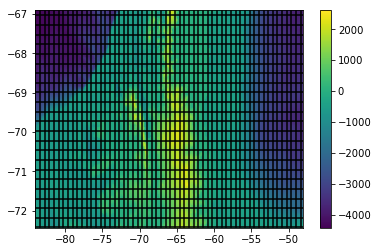

In [16]:
topo_mesh = GMesh.GMesh( lon=topo_lon, lat=topo_lat, from_cell_center=True)
ax = plt.subplot(111)#, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
im= topo_mesh.pcolormesh( ax, topo_elv)#, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax,subsample=10)#, transform=cartopy.crs.PlateCarree())
plt.colorbar(im, ax=ax);

Flag topography cells that are sampled by mesh nodes

non-hit ratio:  585948  /  716124


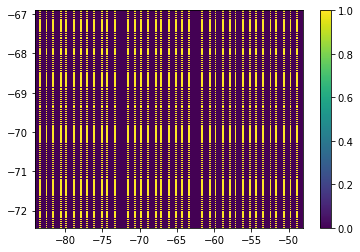

In [17]:
hits = target_mesh.source_hits( topo_lon, topo_lat )

ax = plt.subplot(111) #, projection=cartopy.crs.NearsidePerspective(central_longitude=lonc, central_latitude=latc))
im = topo_mesh.pcolormesh( ax, hits)#, transform=cartopy.crs.PlateCarree() )
plt.colorbar(im, ax=ax);
#target_mesh.plot(ax, linecolor='w', transform=cartopy.crs.Geodetic())
print("non-hit ratio: ",hits.size-hits.sum().astype(int)," / ",hits.size)

Refine grid by 2 till all source points are hit 

In [18]:
Glist = target_mesh.refine_loop( topo_lon, topo_lat , max_mb=8000);

<GMesh nj:225 ni:575 shape:(225,575)> Hit 130176 out of 716124 cells (1.9741 Mb)
<GMesh nj:450 ni:1150 shape:(450,1150)> Hit 383580 out of 716124 cells (7.8964 Mb)
<GMesh nj:900 ni:2300 shape:(900,2300)> Hit 716124 out of 716124 cells (31.5857 Mb)


Sample the topography on the refined grid

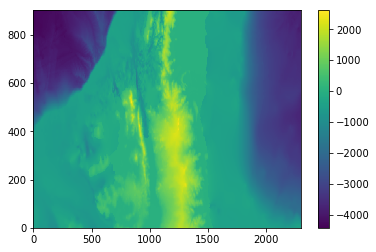

In [19]:
#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
imp.reload(GMesh)

Glist[-1].sample_source_data_on_target_mesh(topo_lon,topo_lat,topo_elv)
#Glist[-1].dump()
plt.pcolormesh(Glist[-1].height);plt.colorbar();